## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'spaceNet-full' 
TRANSFORM = 'wavelet'
CHANNEL = 'green'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
green_wavelet_full_spaceNet.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "groupCDFs")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = True
CWD

'/Users/michaelmurphy/Documents/GitHub/hierarchical-bayesian-model-validation/results/case-studies/spaceNet/full/wavelet/green'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if TRANSFORM == 'fourier':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif TRANSFORM == 'wavelet':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:5]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 27208,
 3: 108832,
 4: 333298,
 5: 1149538,
 6: 4251250,
 7: 17005000,
 8: 68020000,
 9: 272080000}

Running 7880 CDFs


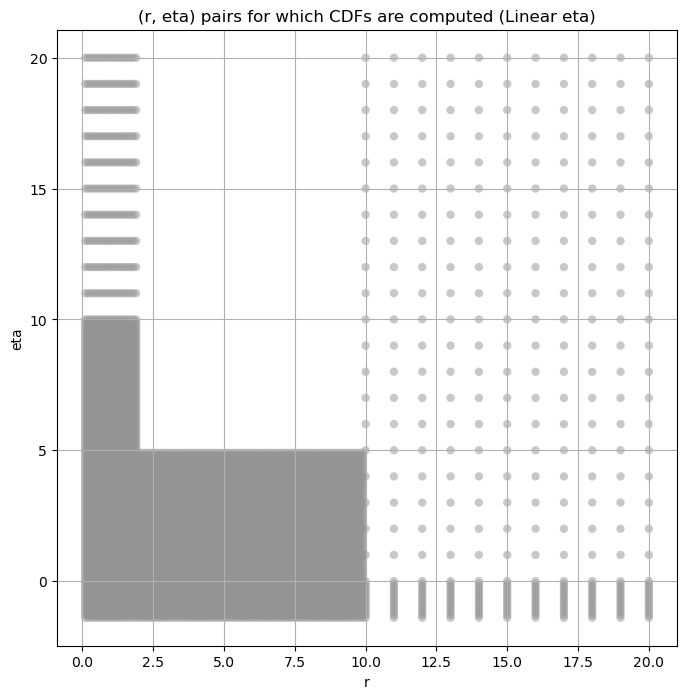

,"(r,eta),cdf",r,eta,cdf,variance,kurtosis
0,"((0.1, -1.4), <scipy.interpolate._fitpack2.Int...",0.1,-1.4,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.628800e+06,554265.000000
1,"((0.1, -1.3), <scipy.interpolate._fitpack2.Int...",0.1,-1.3,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.991680e+07,96192.272727
2,"((0.1, -1.2), <scipy.interpolate._fitpack2.Int...",0.1,-1.2,<scipy.interpolate._fitpack2.InterpolatedUniva...,2.395008e+08,29390.000000
3,"((0.1, -1.1), <scipy.interpolate._fitpack2.Int...",0.1,-1.1,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.037837e+09,11997.692308
4,"((0.1, -1.0), <scipy.interpolate._fitpack2.Int...",0.1,-1.0,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.632429e+09,5874.890110


In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index().drop("index", axis = 1)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples
layer,,,,,,,
2,20586.305000,19258.834000,21997.410000,4.579431,3.067570,6.878069,27208.0
3,5586.053700,5083.016600,6169.916000,12.162226,6.823159,25.537256,108832.0
4,1803.627700,1653.466300,1972.171500,9.509389,6.386564,18.200993,333298.0
5,518.534850,474.725100,568.612800,10.223197,6.527225,26.452090,1149538.0
6,123.448540,112.811350,135.501530,10.628438,6.988415,22.204712,4251250.0
7,26.475042,23.729494,30.003483,18.552206,9.779295,60.441100,17005000.0
8,5.566629,4.825312,6.911863,45.449364,13.917338,216.893890,68020000.0
9,1.022354,0.857071,1.428720,105.088615,15.796925,464.369140,272080000.0


## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

,obs_var,var_exclude_0,var_exclude_25,var_exclude_50,var_exclude_75,var_exclude_100,var_exclude_150,var_exclude_200,var_exclude_250,var_exclude_300,var_exclude_350,var_exclude_500
layer,,,,,,,,,,,,
2,20586.305000,20586.304688,19327.347656,18633.119141,18071.654297,17581.865234,16734.597656,16020.081055,15399.475586,14845.157227,14336.458984,13035.785156
3,5586.053700,5586.053711,5321.499023,5194.318359,5091.334473,5001.950684,4847.855469,4717.403320,4602.026855,4497.152344,4401.330566,4152.587402
4,1803.627700,1803.627686,1735.336182,1696.418823,1664.522217,1636.697021,1588.497192,1546.772705,1509.815796,1476.339966,1445.373657,1364.696289
5,518.534850,518.534851,499.054321,487.949280,478.679108,470.541168,456.467407,444.315735,433.500275,423.714996,414.718781,391.181427
6,123.448540,123.448540,118.563980,115.736794,113.421310,111.401886,107.937408,104.980782,102.354362,99.974098,97.789276,92.085861
7,26.475042,26.475042,25.031528,24.278843,23.676111,23.159885,22.285866,21.547445,20.900084,20.319300,19.789978,18.426332
8,5.566629,5.566629,5.114072,4.913289,4.757011,4.625782,4.408626,4.229403,4.075031,3.938550,3.815841,3.506121
9,1.022354,1.022354,0.905714,0.865081,0.834507,0.809310,0.768349,0.735163,0.706954,0.682263,0.660240,0.605310


####
Layer  2


  0%|          | 0/7880 [00:00<?, ?it/s]

Finding Minimum after computing 7880 CDFs
2 0 0.013993395045369783 20586.305


  0%|          | 0/7880 [00:00<?, ?it/s]

Finding Minimum after computing 7880 CDFs
2 25 0.01408919660477903 19327.348


  0%|          | 0/7880 [00:00<?, ?it/s]

Finding Minimum after computing 7880 CDFs
2 50 0.014174190456876512 18633.12
Number of samples: 27208, Without approximation : 27208.0


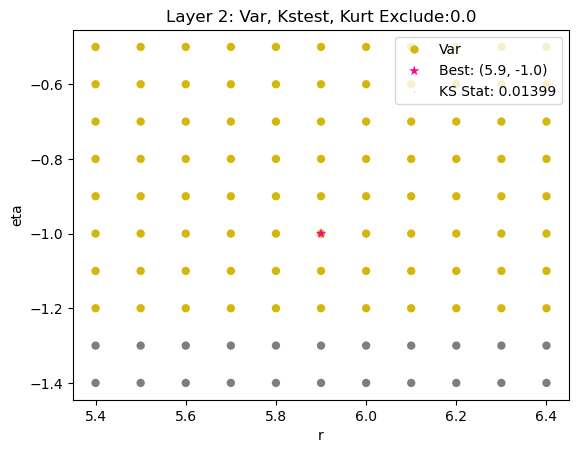

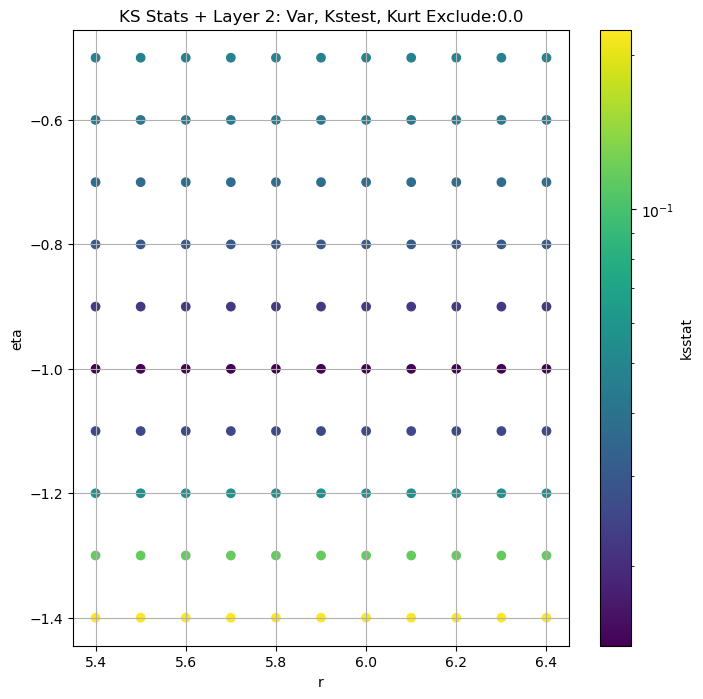

####
Layer  3


  0%|          | 0/7880 [00:00<?, ?it/s]

Finding Minimum after computing 7880 CDFs
3 0 0.13297999999999977 5586.0537


  0%|          | 0/7880 [00:00<?, ?it/s]

Finding Minimum after computing 7880 CDFs
3 25 0.13297999999999977 5321.499


  0%|          | 0/7880 [00:00<?, ?it/s]

Finding Minimum after computing 7880 CDFs
3 50 0.13297999999999977 5194.3184
Number of samples: 100000, Without approximation : 108832.0


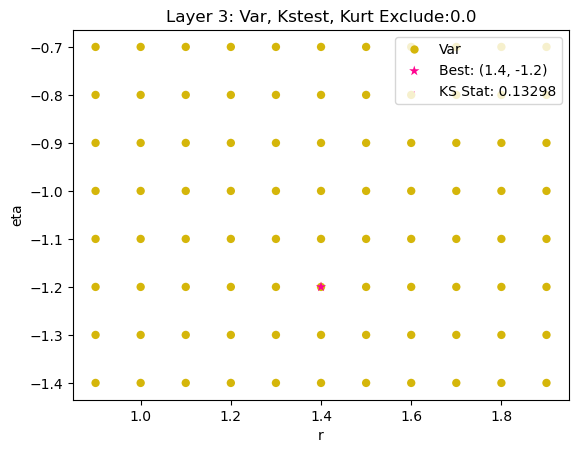

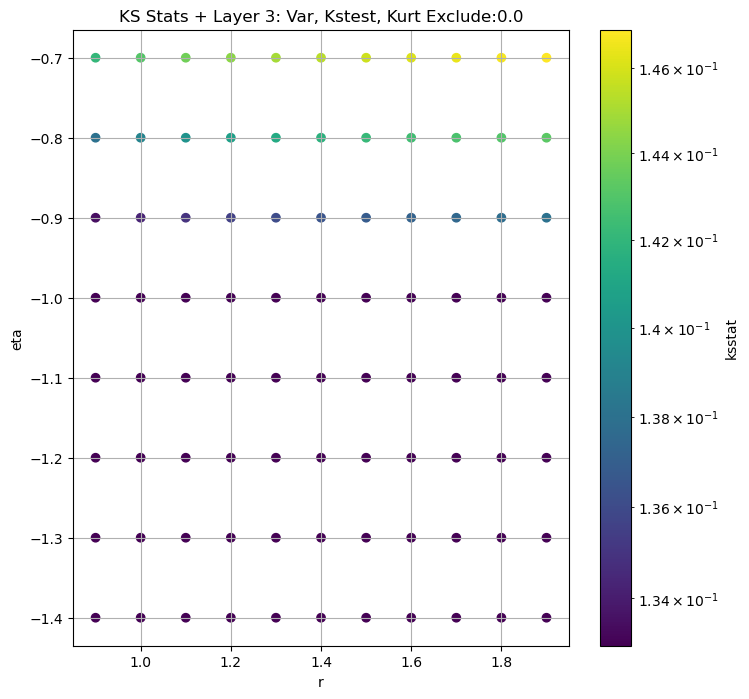

####
Layer  4


  0%|          | 0/7880 [00:00<?, ?it/s]

Finding Minimum after computing 7880 CDFs
4 0 0.07775999999999977 1803.6277


  0%|          | 0/7880 [00:00<?, ?it/s]

Finding Minimum after computing 7880 CDFs
4 25 0.07775999999999977 1735.3362


  0%|          | 0/7880 [00:00<?, ?it/s]

Finding Minimum after computing 7880 CDFs
4 50 0.07775999999999977 1696.4188
Number of samples: 100000, Without approximation : 333298.0


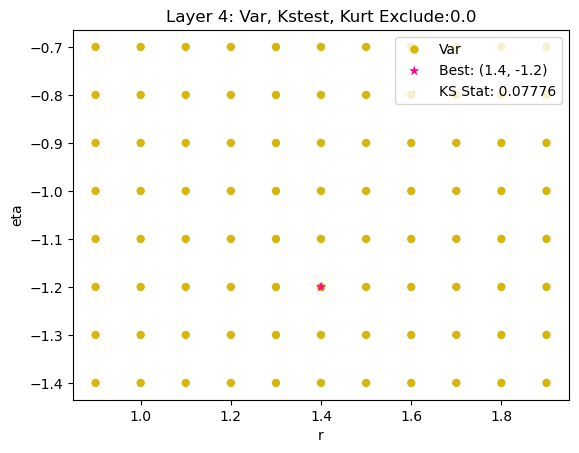

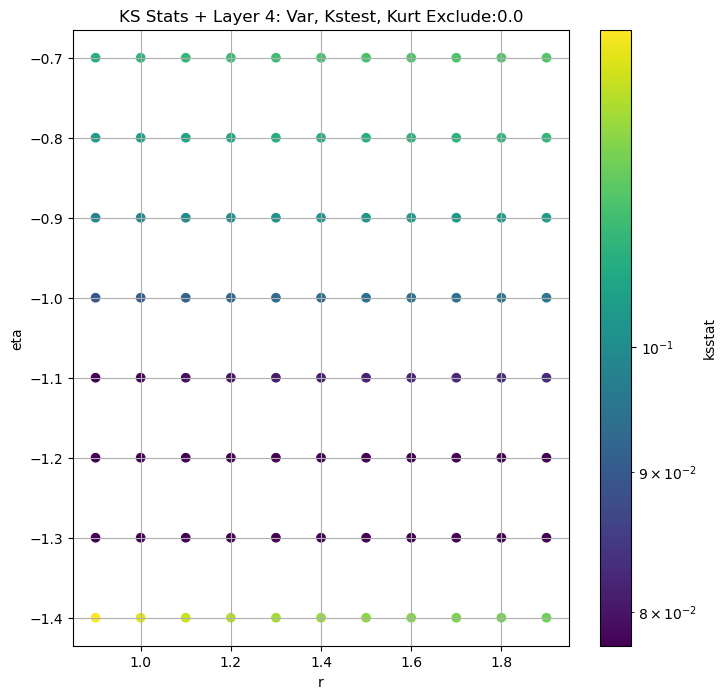

####
Layer  5


  0%|          | 0/7880 [00:00<?, ?it/s]

Finding Minimum after computing 7880 CDFs
5 0 0.04298999999999975 518.53485


  0%|          | 0/7880 [00:00<?, ?it/s]

Finding Minimum after computing 7880 CDFs
5 25 0.04298999999999975 499.05432


  0%|          | 0/7880 [00:00<?, ?it/s]

Finding Minimum after computing 7880 CDFs
5 50 0.04298999999999975 487.94928
Number of samples: 100000, Without approximation : 1149538.0


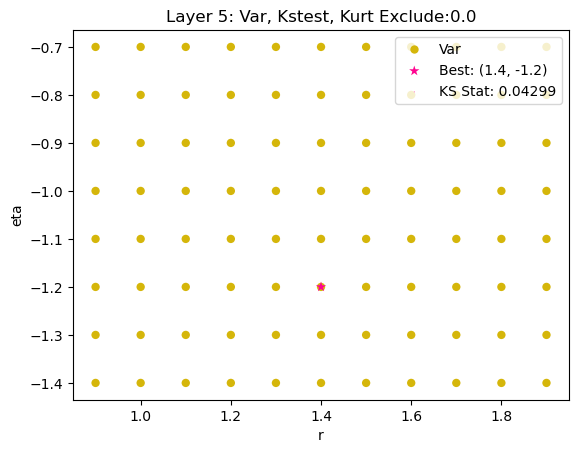

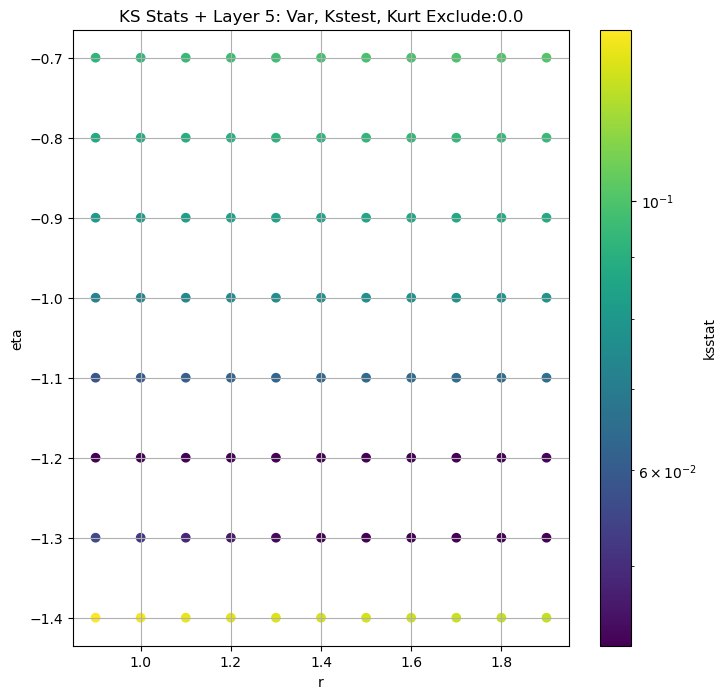

####
Layer  6


  0%|          | 0/7880 [00:00<?, ?it/s]

Finding Minimum after computing 7880 CDFs
6 0 0.013469313611412903 123.44854


  0%|          | 0/7880 [00:00<?, ?it/s]

Finding Minimum after computing 7880 CDFs
6 25 0.013966205572017665 118.56398


  0%|          | 0/7880 [00:00<?, ?it/s]

Finding Minimum after computing 7880 CDFs
6 50 0.013503134754856871 115.73679
Number of samples: 100000, Without approximation : 4251250.0


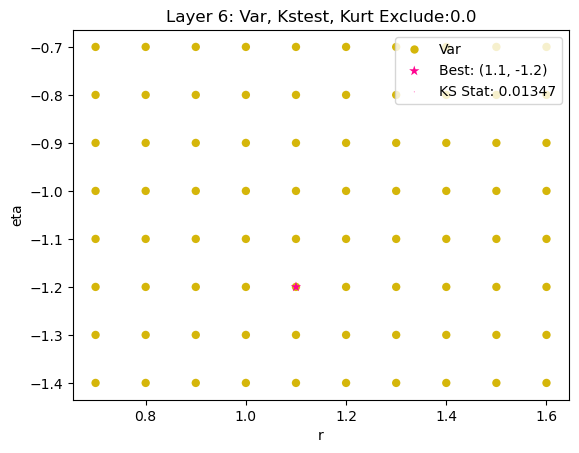

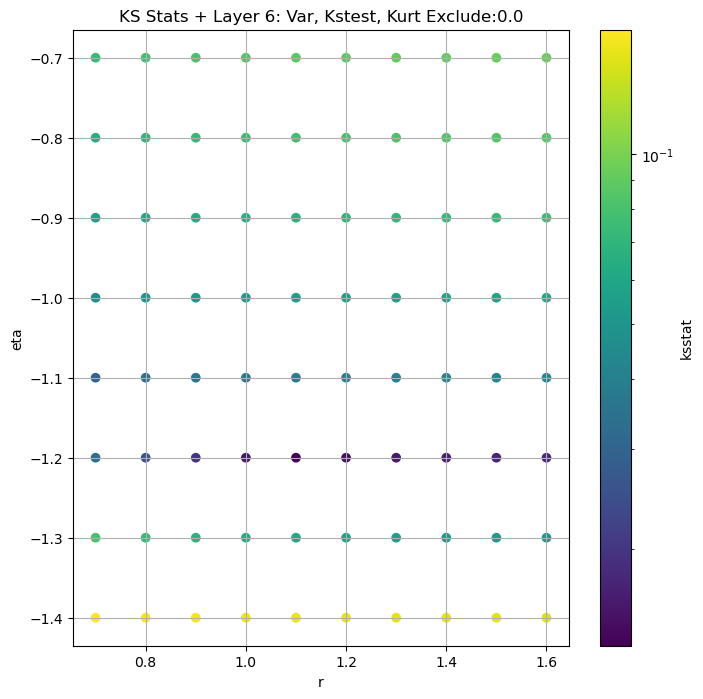

####
Layer  7


  0%|          | 0/7880 [00:00<?, ?it/s]

Finding Minimum after computing 7880 CDFs
7 0 0.012878795454322023 26.475042


  0%|          | 0/7880 [00:00<?, ?it/s]

Finding Minimum after computing 7880 CDFs
7 25 0.013258002588977524 25.031528


  0%|          | 0/7880 [00:00<?, ?it/s]

Finding Minimum after computing 7880 CDFs
7 50 0.012729853451409034 24.278843


  0%|          | 0/7880 [00:00<?, ?it/s]

Finding Minimum after computing 7880 CDFs
7 75 0.01286426607208735 23.676111
Number of samples: 100000, Without approximation : 17005000.0


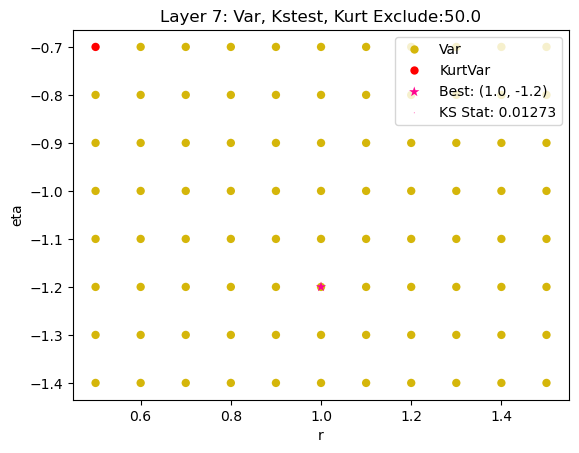

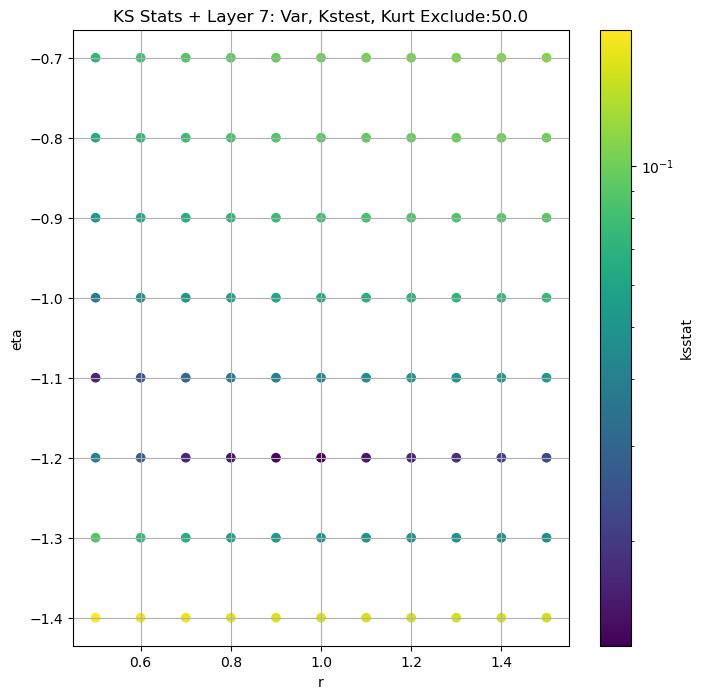

####
Layer  8


  0%|          | 0/7880 [00:00<?, ?it/s]

Finding Minimum after computing 7880 CDFs
8 0 0.014539817297752666 5.5666294


  0%|          | 0/7880 [00:00<?, ?it/s]

Finding Minimum after computing 7880 CDFs
8 25 0.011122364313074118 5.114072


  0%|          | 0/7880 [00:00<?, ?it/s]

Finding Minimum after computing 7880 CDFs
8 50 0.01050313822343825 4.913289


  0%|          | 0/7880 [00:00<?, ?it/s]

Finding Minimum after computing 7880 CDFs
8 75 0.012209917104412257 4.7570114


  0%|          | 0/7880 [00:00<?, ?it/s]

Finding Minimum after computing 7880 CDFs
8 100 0.013702072630065718 4.6257825
Number of samples: 100000, Without approximation : 68020000.0


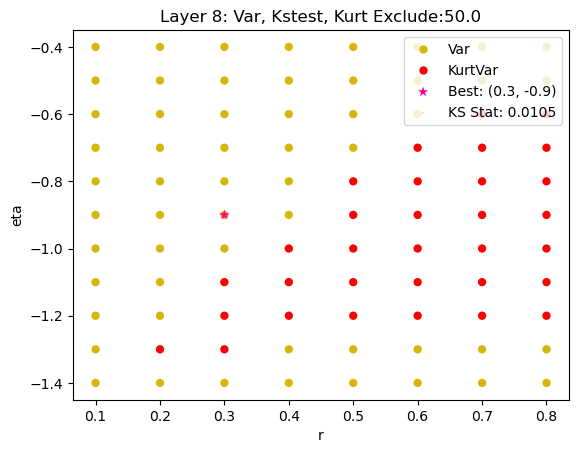

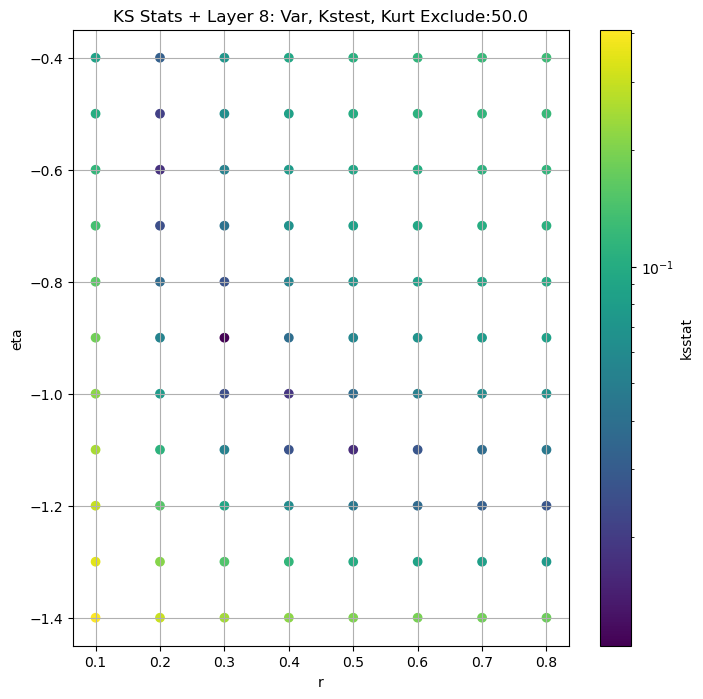

####
Layer  9


  0%|          | 0/7880 [00:00<?, ?it/s]

Finding Minimum after computing 7880 CDFs
9 0 0.007983989523384916 1.0223536


  0%|          | 0/7880 [00:00<?, ?it/s]

Finding Minimum after computing 7880 CDFs
9 25 0.008378506661171015 0.90571374


  0%|          | 0/7880 [00:00<?, ?it/s]

Finding Minimum after computing 7880 CDFs
9 50 0.007386213172714581 0.86508065


  0%|          | 0/7880 [00:00<?, ?it/s]

Finding Minimum after computing 7880 CDFs
9 75 0.007674106661168606 0.83450705
Number of samples: 100000, Without approximation : 272080000.0


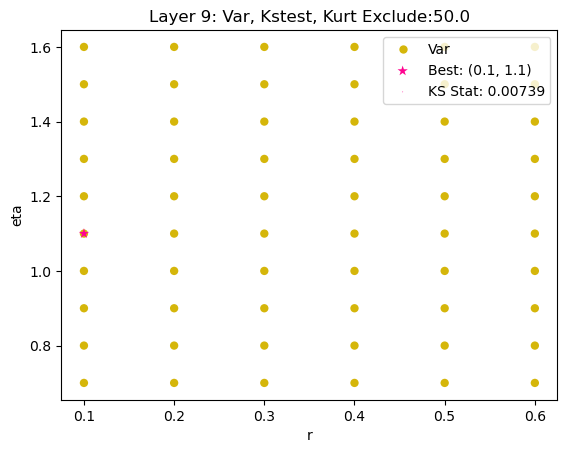

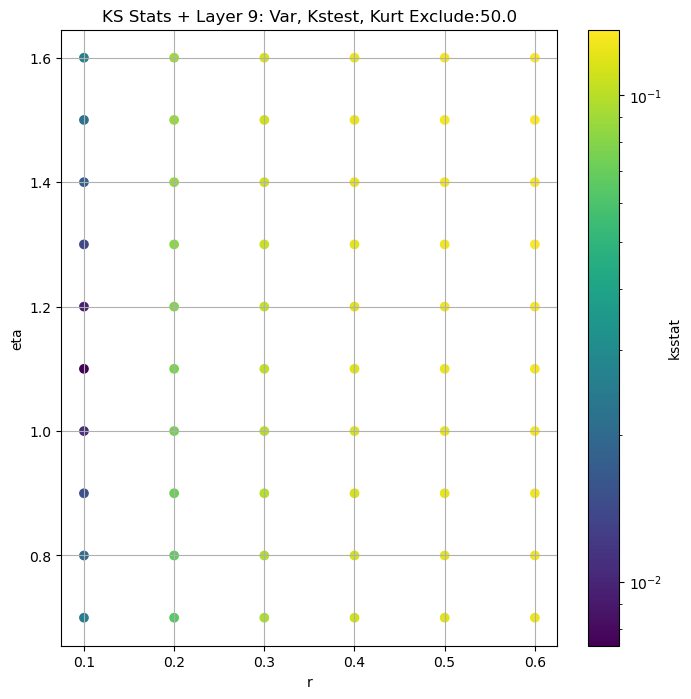

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,initial_scale,initial_exclude_cutoff,best_augmented_var,kstest_stat_cutoff_0.05
layer,,,,,,,,,,,,,,
2,20586.305000,19258.834000,21997.410000,4.579431,3.067570,6.878069,27208.0,0.013993,5.9,-1.0,6.531506e+04,0.0,20586.305000,0.008227
3,5586.053700,5083.016600,6169.916000,12.162226,6.823159,25.537256,108832.0,0.132980,1.4,-1.2,2.277729e+04,0.0,5586.053700,0.004115
4,1803.627700,1653.466300,1972.171500,9.509389,6.386564,18.200993,333298.0,0.077760,1.4,-1.2,7.354343e+03,0.0,1803.627700,0.002352
5,518.534850,474.725100,568.612800,10.223197,6.527225,26.452090,1149538.0,0.042990,1.4,-1.2,2.114341e+03,0.0,518.534850,0.001267
6,123.448540,112.811350,135.501530,10.628438,6.988415,22.204712,4251250.0,0.013469,1.1,-1.2,4.422523e+02,0.0,123.448540,0.000659
7,26.475042,23.729494,30.003483,18.552206,9.779295,60.441100,17005000.0,0.012730,1.0,-1.2,8.092948e+01,50.0,24.278843,0.000329
8,5.566629,4.825312,6.911863,45.449364,13.917338,216.893890,68020000.0,0.010503,0.3,-0.9,1.224375e-01,50.0,4.913289,0.000165
9,1.022354,0.857071,1.428720,105.088615,15.796925,464.369140,272080000.0,0.007386,0.1,1.1,1.298583e-15,50.0,0.865081,0.000082


In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1
        no_improvement_counter = 0

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]

            if no_improvement_counter > 1:
                break

            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
            else:
                no_improvement_counter += 1
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

In [13]:
augmented_var_df

,obs_var,var_exclude_0,var_exclude_25,var_exclude_50,var_exclude_75,var_exclude_100,var_exclude_150,var_exclude_200,var_exclude_250,var_exclude_300,var_exclude_350,var_exclude_500,kstest_stat_0,kstest_stat_25,kstest_stat_50,kstest_stat_75,kstest_stat_100
layer,,,,,,,,,,,,,,,,,
2,20586.305000,20586.305000,19327.348000,18633.120000,18071.654000,17581.865000,16734.598000,16020.081000,15399.476000,14845.157000,14336.459000,13035.785000,0.013993,0.014089,0.014174,NaN,NaN
3,5586.053700,5586.053700,5321.499000,5194.318400,5091.334500,5001.950700,4847.855500,4717.403300,4602.027000,4497.152300,4401.330600,4152.587400,0.132980,0.132980,0.132980,NaN,NaN
4,1803.627700,1803.627700,1735.336200,1696.418800,1664.522200,1636.697000,1588.497200,1546.772700,1509.815800,1476.340000,1445.373700,1364.696300,0.077760,0.077760,0.077760,NaN,NaN
5,518.534850,518.534850,499.054320,487.949280,478.679100,470.541170,456.467400,444.315730,433.500270,423.715000,414.718780,391.181430,0.042990,0.042990,0.042990,NaN,NaN
6,123.448540,123.448540,118.563980,115.736790,113.421310,111.401886,107.937410,104.980780,102.354360,99.974100,97.789276,92.085860,0.013469,0.013966,0.013503,NaN,NaN
7,26.475042,26.475042,25.031528,24.278843,23.676111,23.159885,22.285866,21.547445,20.900084,20.319300,19.789978,18.426332,0.012879,0.013258,0.012730,0.012864,NaN
8,5.566629,5.566629,5.114072,4.913289,4.757011,4.625782,4.408626,4.229402,4.075031,3.938550,3.815841,3.506121,0.014540,0.011122,0.010503,0.012210,0.013702
9,1.022354,1.022354,0.905714,0.865081,0.834507,0.809310,0.768349,0.735163,0.706954,0.682263,0.660240,0.605310,0.007984,0.008379,0.007386,0.007674,NaN


In [14]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

In [15]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(-50, 51, 10)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            r_granularity = 1
            eta_granularity = 1
            for i in range(0, -5, -1):
                if tuple([round_to_sigfigs(initial_r + 10.**i, 8), round_to_sigfigs(initial_eta, 1)]) in all_cdfs:
                    r_granularity = 10.**i
                if tuple([round_to_sigfigs(initial_r, 1), round_to_sigfigs(initial_eta + 10.**i, 8)]) in all_cdfs:
                    eta_granularity = 10.**i
                    
            for d in range(1, NUM_ITERS[group] + 1):
                if d == 1:
                    initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
                else:
                    initial_r, initial_eta = master_df.loc[group, f'iter{d - 1}_r'], master_df.loc[group, f'iter{d - 1}_eta']

                r_granularity = r_granularity * 10.0**(-d+1) 
                eta_granularity = eta_granularity * 10.0**(-d+1) 

                r_range = [round_to_sigfigs(x) for x in np.arange(initial_r - r_granularity, initial_r + r_granularity, r_granularity/10)]
                eta_range = [round_to_sigfigs(x) for x in np.arange(initial_eta - eta_granularity, initial_eta + eta_granularity, eta_granularity/10)]
                simple_add_cdfs(r_range, eta_range, dir = os.path.join(CWD, "groupCDFs"), folder_name=f'{GROUP}{group}', n_samples = NUM_SAMPLES_OPTIMIZE, debug=False, tail_bound=1e-5)
                group_cdfs = combine_pickles(os.path.join(CWD, "groupCDFs", f'{GROUP}{group}'))
                group_cdfs_df = create_kurt_var_ksstat_df(group_cdfs)

                for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                    exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                    
                    if exclude_cutoff == 0:
                        augmented_var = np.var(group_data_map[group])
                    else:
                        augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                    group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                    ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                    
                    cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                    augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                    group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                    
                    print(group, adjust_exclude_cutoff, exclude_cutoff, min_stat, augmented_var, cutoff_label)
                    best_adjust = 0

                    if min_stat < master_df.loc[group, 'kstest_stat_best']:

                        inital_min_stat = min_stat
                        inital_best_param = initial_param
                        master_df.loc[group, 'kstest_stat_best'] = min_stat
                        initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                        master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                        master_df.loc[group, 'best_scale'] = initial_scale
                        master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                        master_df.loc[group, 'best_augmented_var'] = augmented_var
                        augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                        best_adjust = adjust_exclude_cutoff

                cutoff_label = generate_cutoff_label(best_adjust)
                ksstats = group_cdfs_df[f"ksstat_exclude_{best_adjust}"]
                
                print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
                
                cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
                master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

                best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

                group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
                group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

                group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

                group_dict = rEtaKsstats_dict[group]
                group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
                rEtaKsstats_dict[group] = group_dict

                print(f"Iter {d} {GROUP} {group} best parameters: {master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'], master_df.loc[group, 'best_scale'], master_df.loc[group, 'best_exclude_cutoff'], master_df.loc[group, f'kstest_stat_best']}")

            filtered_df = group_cdfs_df[(group_cdfs_df['r'] > master_df.loc[group, 'initial_r'] - r_granularity) & 
                            (group_cdfs_df['r'] < master_df.loc[group, 'initial_r'] + r_granularity) &
                            (group_cdfs_df['eta'] > master_df.loc[group, 'initial_eta'] - eta_granularity) &
                            (group_cdfs_df['eta'] < master_df.loc[group, 'initial_eta'] + eta_granularity)]
            
            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(filtered_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)

master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,initial_scale,initial_exclude_cutoff,best_augmented_var,kstest_stat_cutoff_0.05,kstest_stat_best,best_r,best_eta,best_scale,best_exclude_cutoff,n_pval_0.05
layer,,,,,,,,,,,,,,,,,,,,
2,20586.305000,19258.834000,21997.410000,4.579431,3.067570,6.878069,27208.0,0.013993,5.9,-1.0,6.531506e+04,0.0,20586.305000,0.008227,0.013993,5.9,-1.0,6.531506e+04,0.0,9682
3,5586.053700,5083.016600,6169.916000,12.162226,6.823159,25.537256,108832.0,0.132980,1.4,-1.2,2.277729e+04,0.0,5586.053700,0.004115,0.132980,1.4,-1.2,2.277729e+04,0.0,106
4,1803.627700,1653.466300,1972.171500,9.509389,6.386564,18.200993,333298.0,0.077760,1.4,-1.2,7.354343e+03,0.0,1803.627700,0.002352,0.077760,1.4,-1.2,7.354343e+03,0.0,306
5,518.534850,474.725100,568.612800,10.223197,6.527225,26.452090,1149538.0,0.042990,1.4,-1.2,2.114341e+03,0.0,518.534850,0.001267,0.042990,1.4,-1.2,2.114341e+03,0.0,945
6,123.448540,112.811350,135.501530,10.628438,6.988415,22.204712,4251250.0,0.013469,1.1,-1.2,4.422523e+02,0.0,123.448540,0.000659,0.013469,1.1,-1.2,4.422523e+02,0.0,10507
7,26.475042,23.729494,30.003483,18.552206,9.779295,60.441100,17005000.0,0.012730,1.0,-1.2,8.092948e+01,50.0,24.278843,0.000329,0.012730,1.0,-1.2,8.092948e+01,50.0,11820
8,5.566629,4.825312,6.911863,45.449364,13.917338,216.893890,68020000.0,0.010503,0.3,-0.9,1.224375e-01,50.0,4.913289,0.000165,0.010503,0.3,-0.9,1.224375e-01,50.0,16606
9,1.022354,0.857071,1.428720,105.088615,15.796925,464.369140,272080000.0,0.007386,0.1,1.1,1.298583e-15,50.0,0.865081,0.000082,0.007386,0.1,1.1,1.298583e-15,50.0,33212


## Comparing Empirical and Computed CDF/PDF

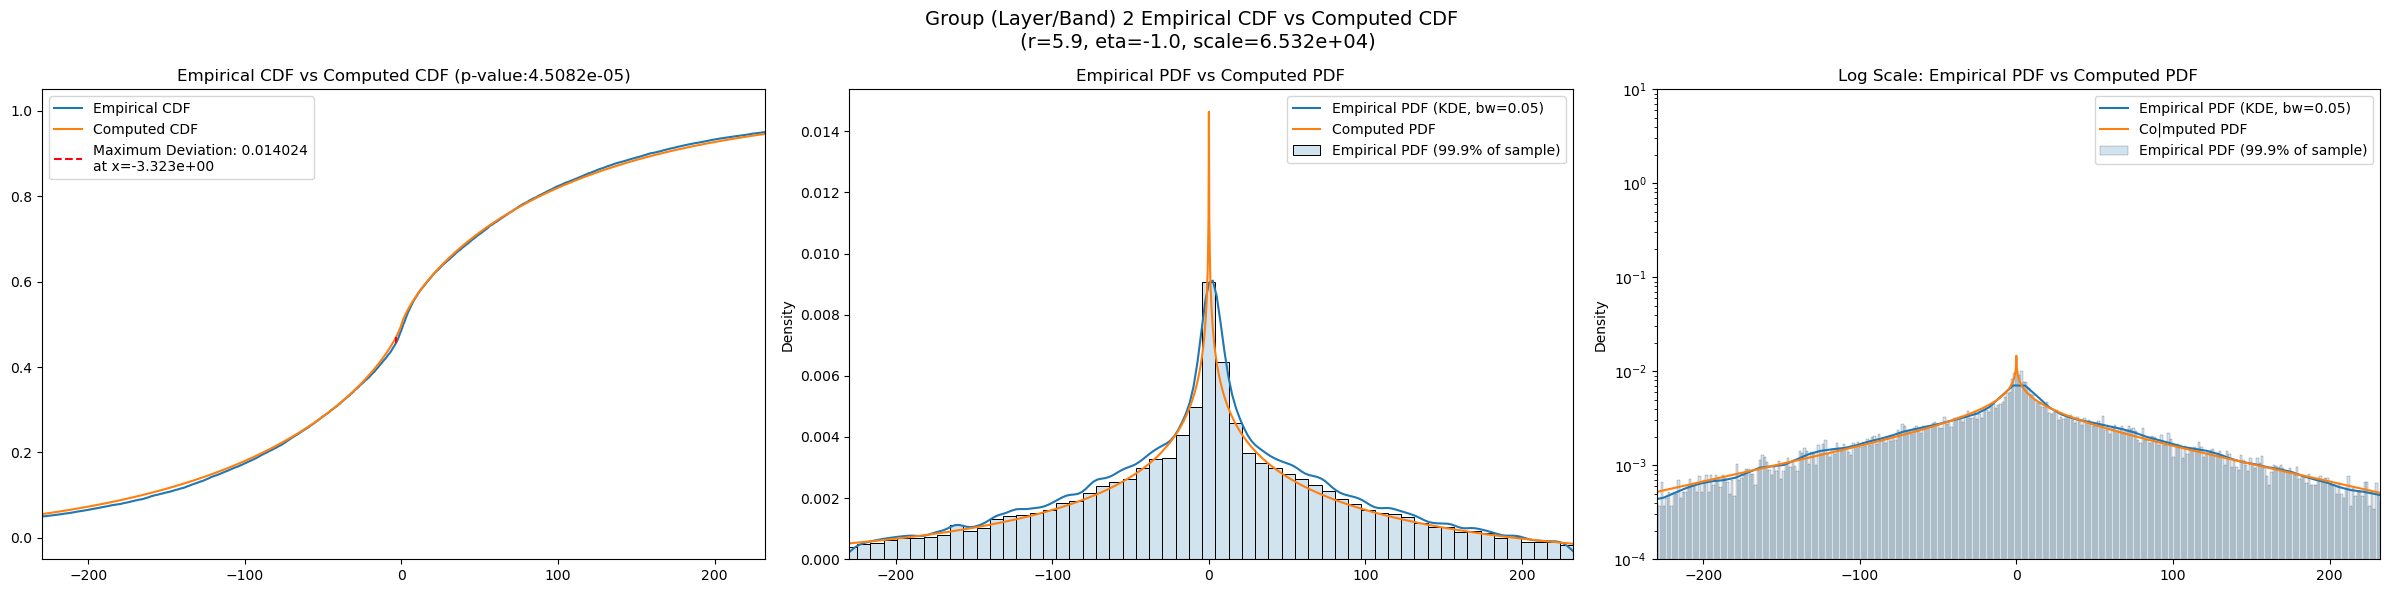

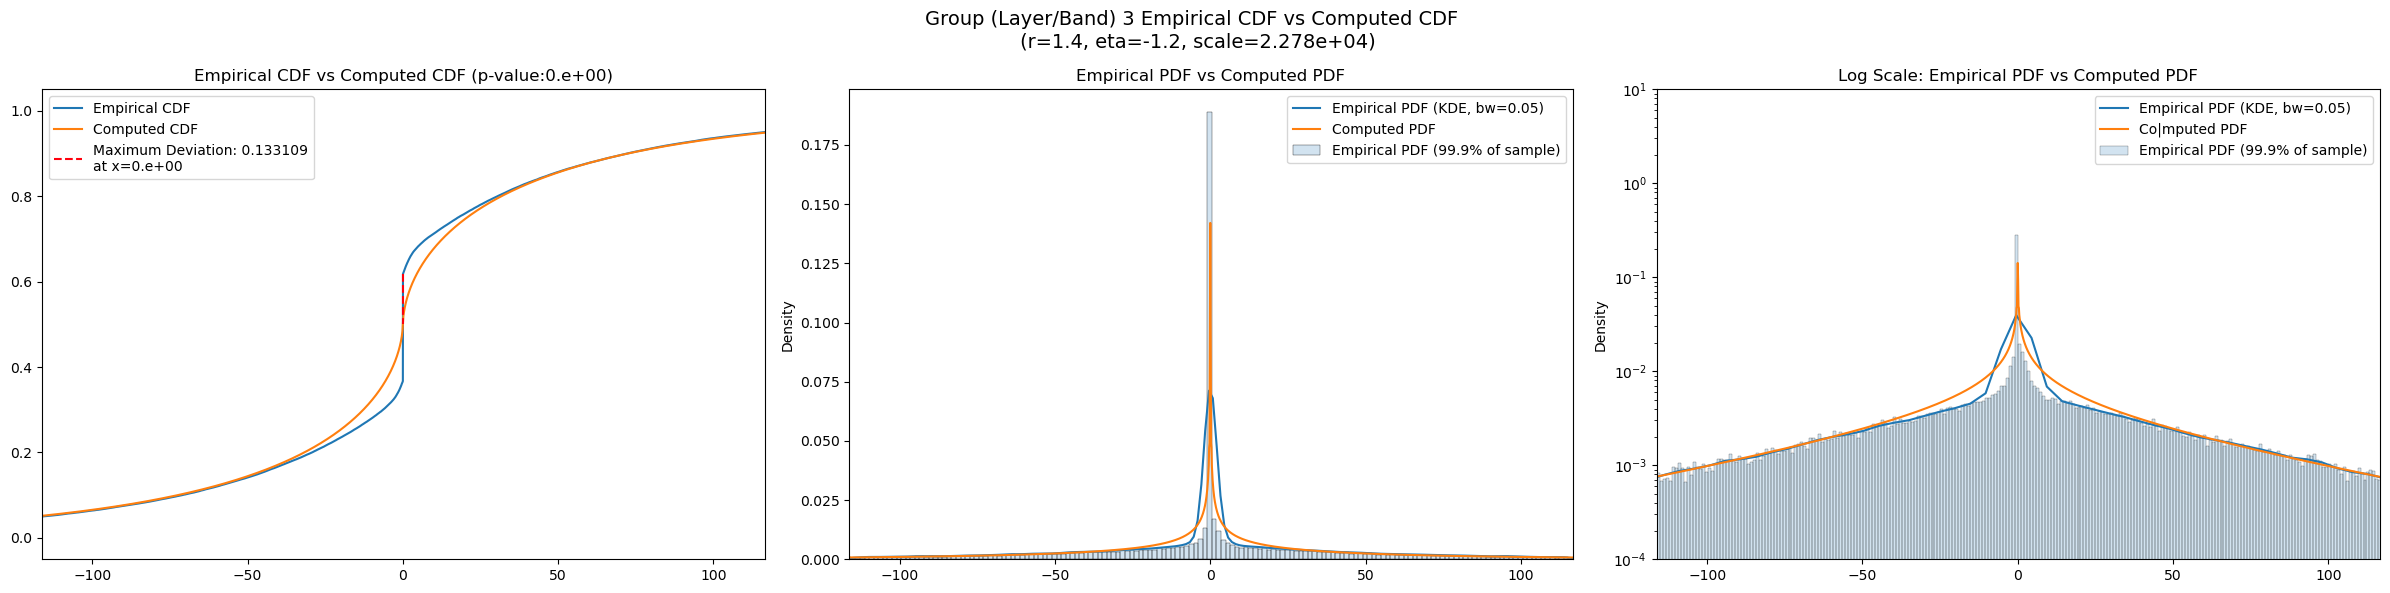

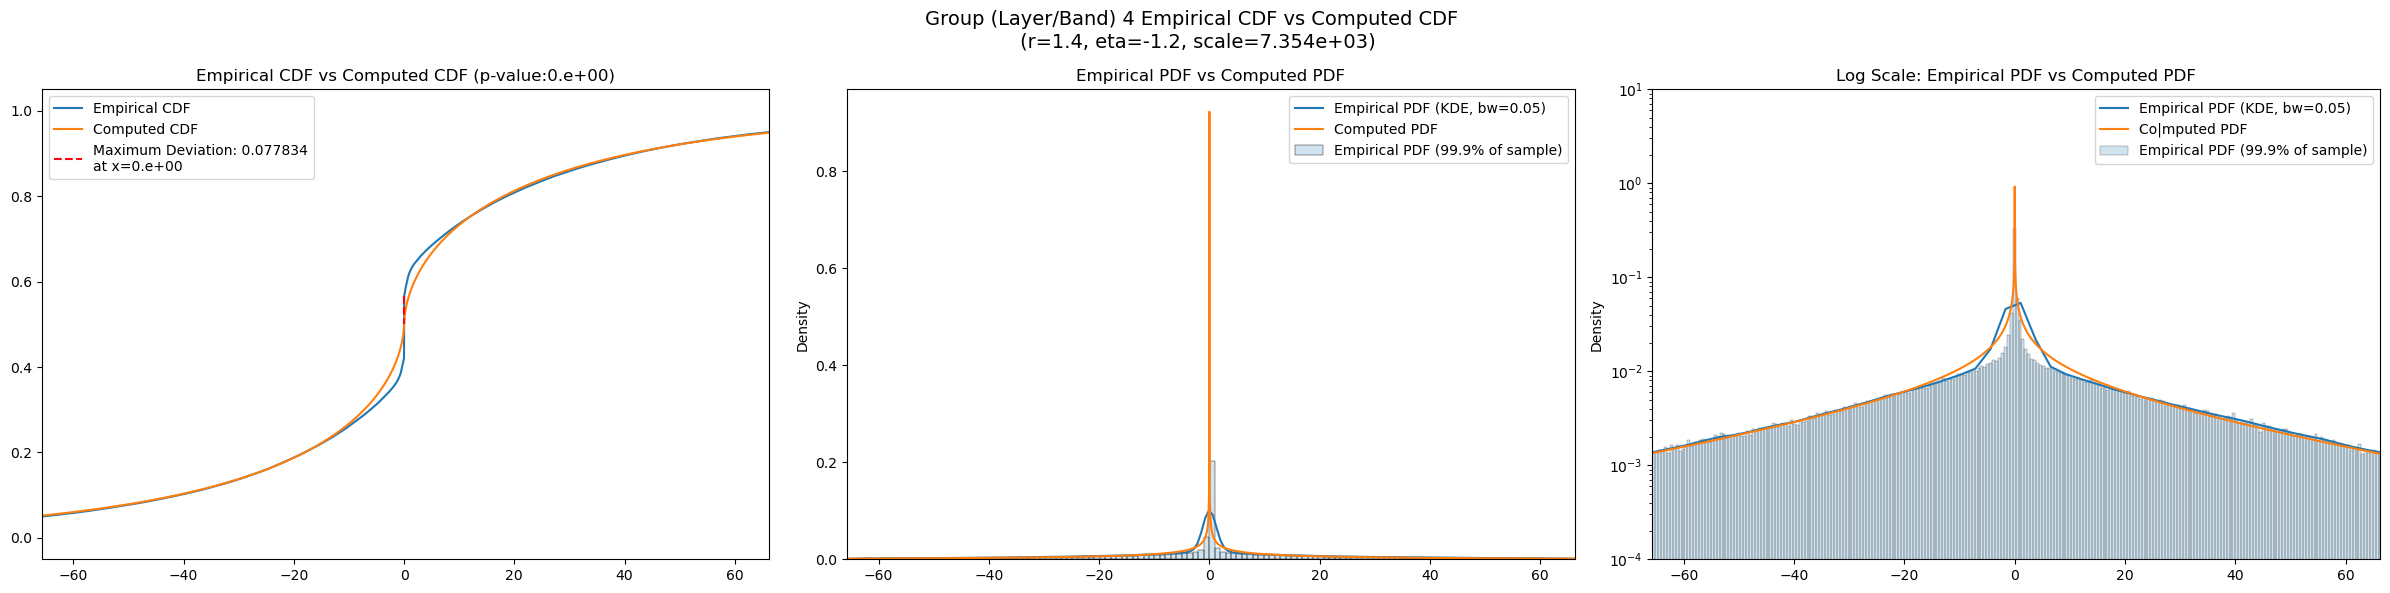

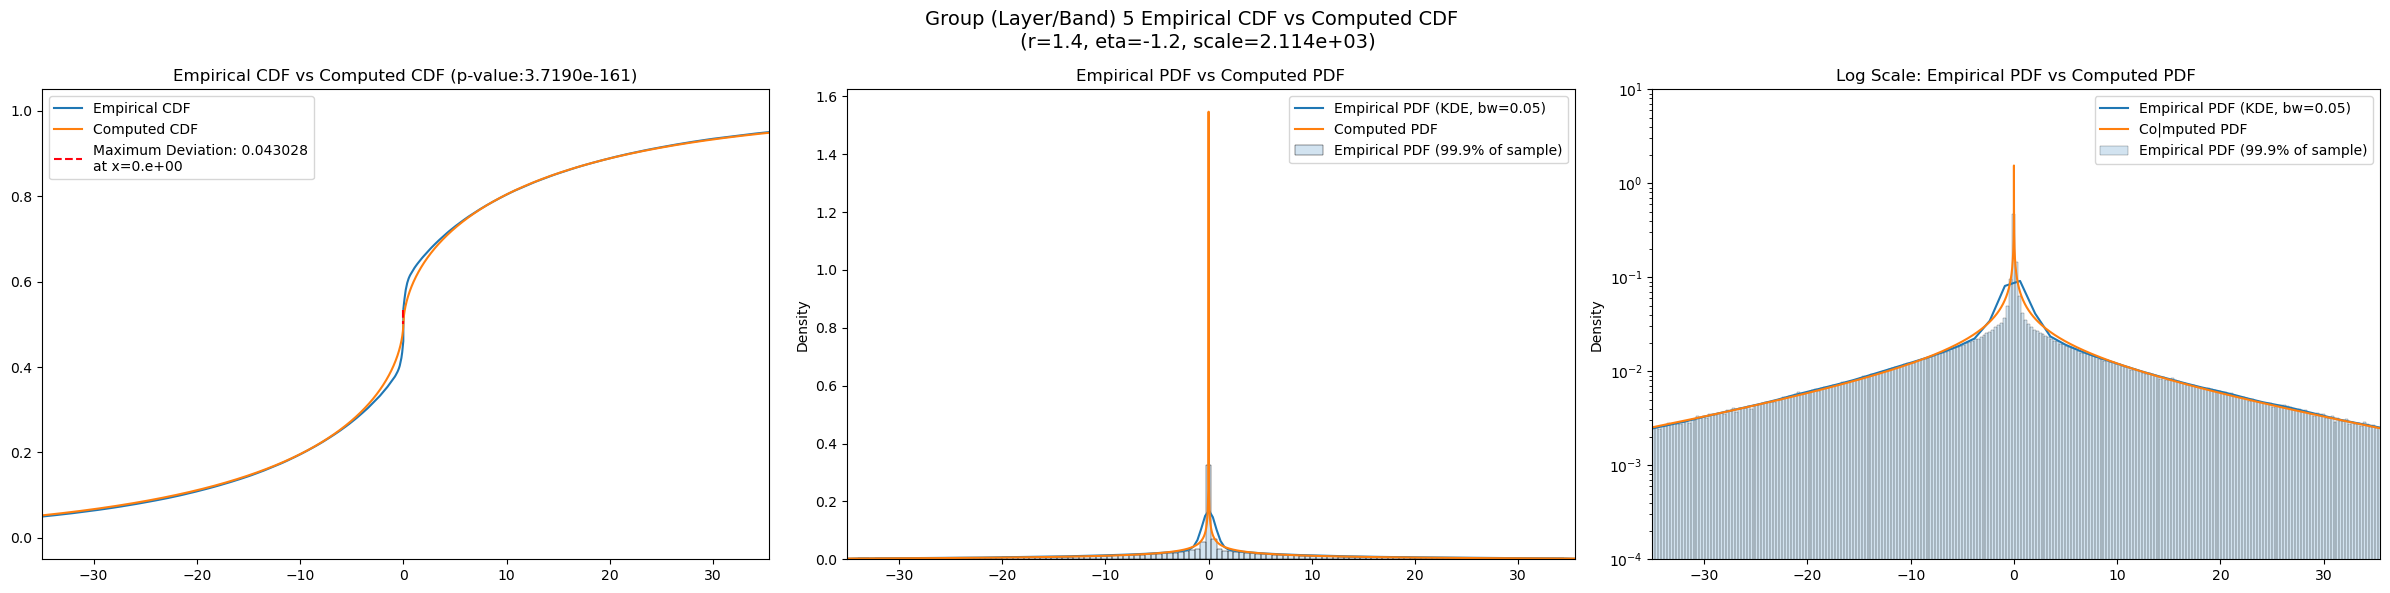

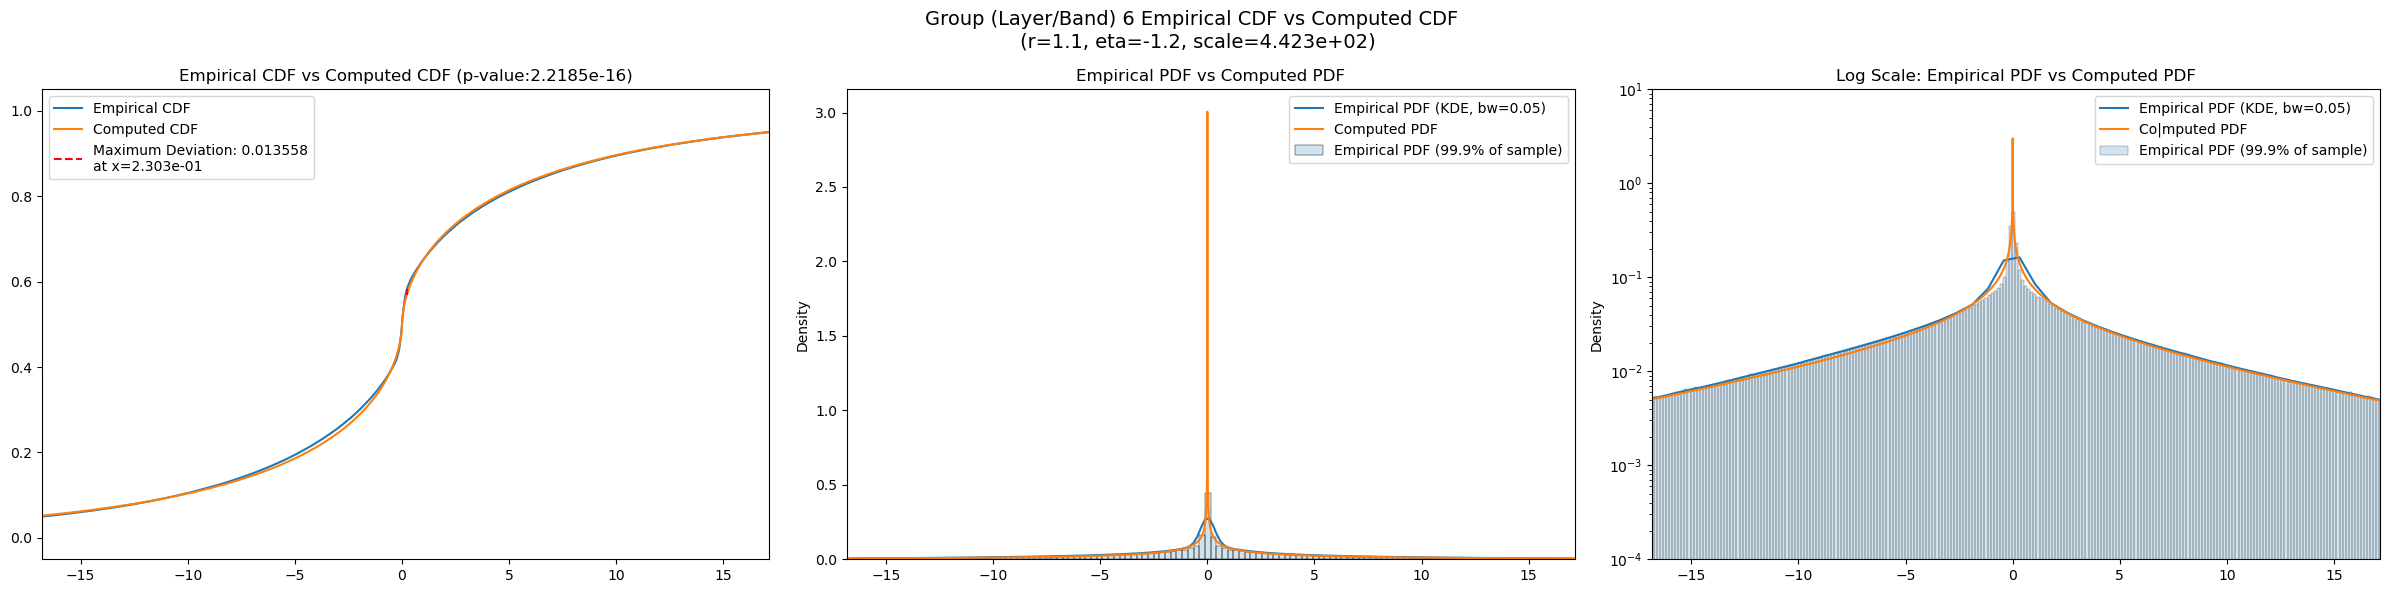

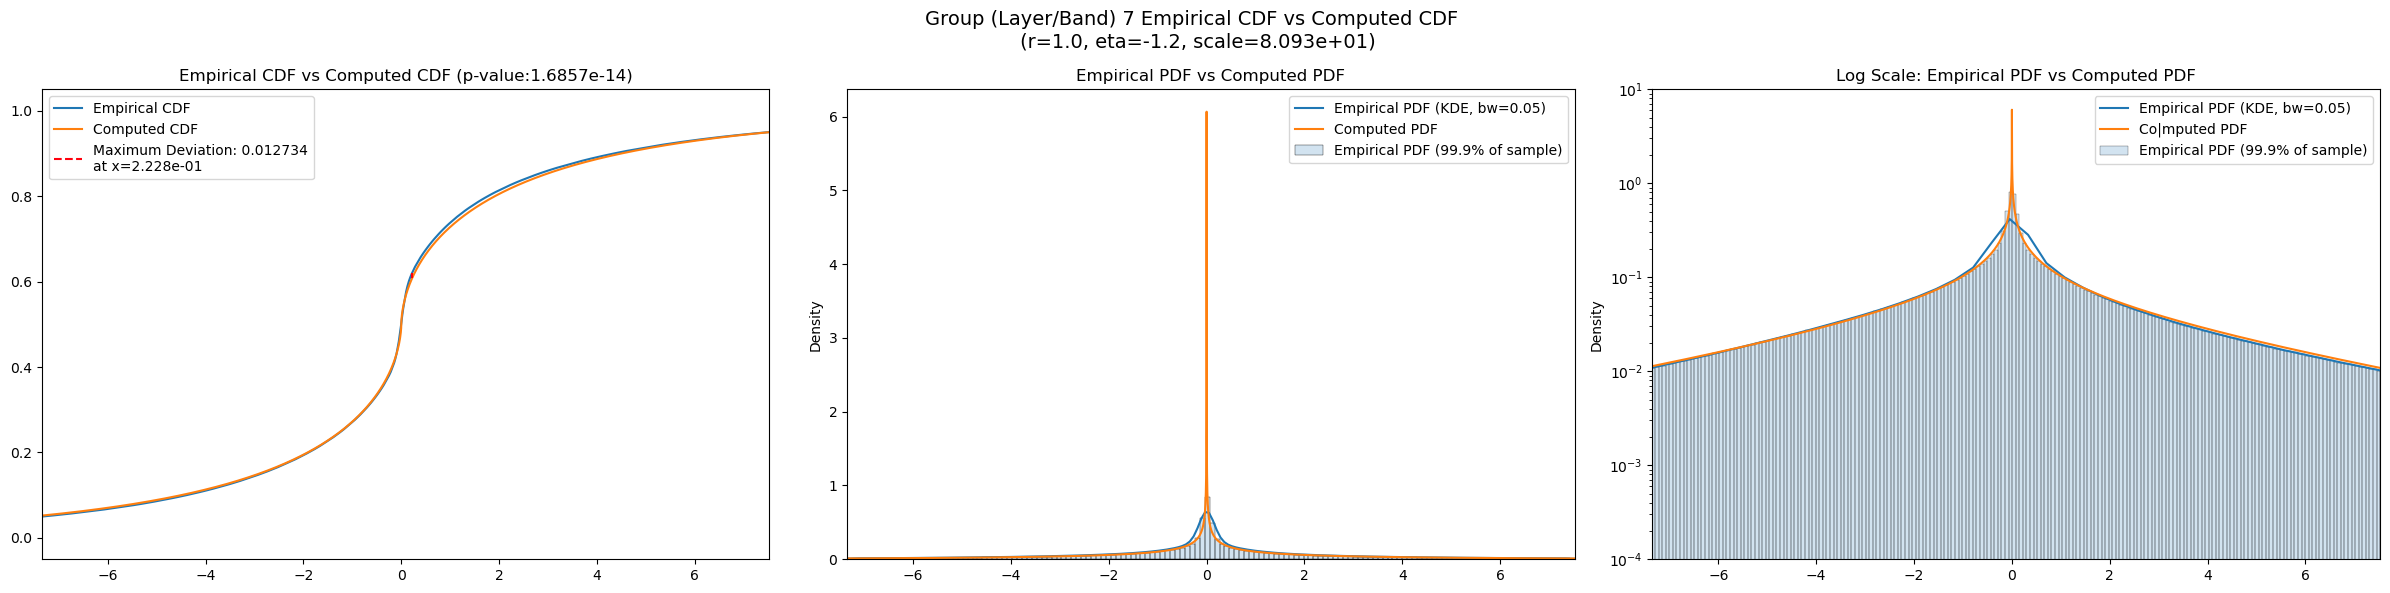

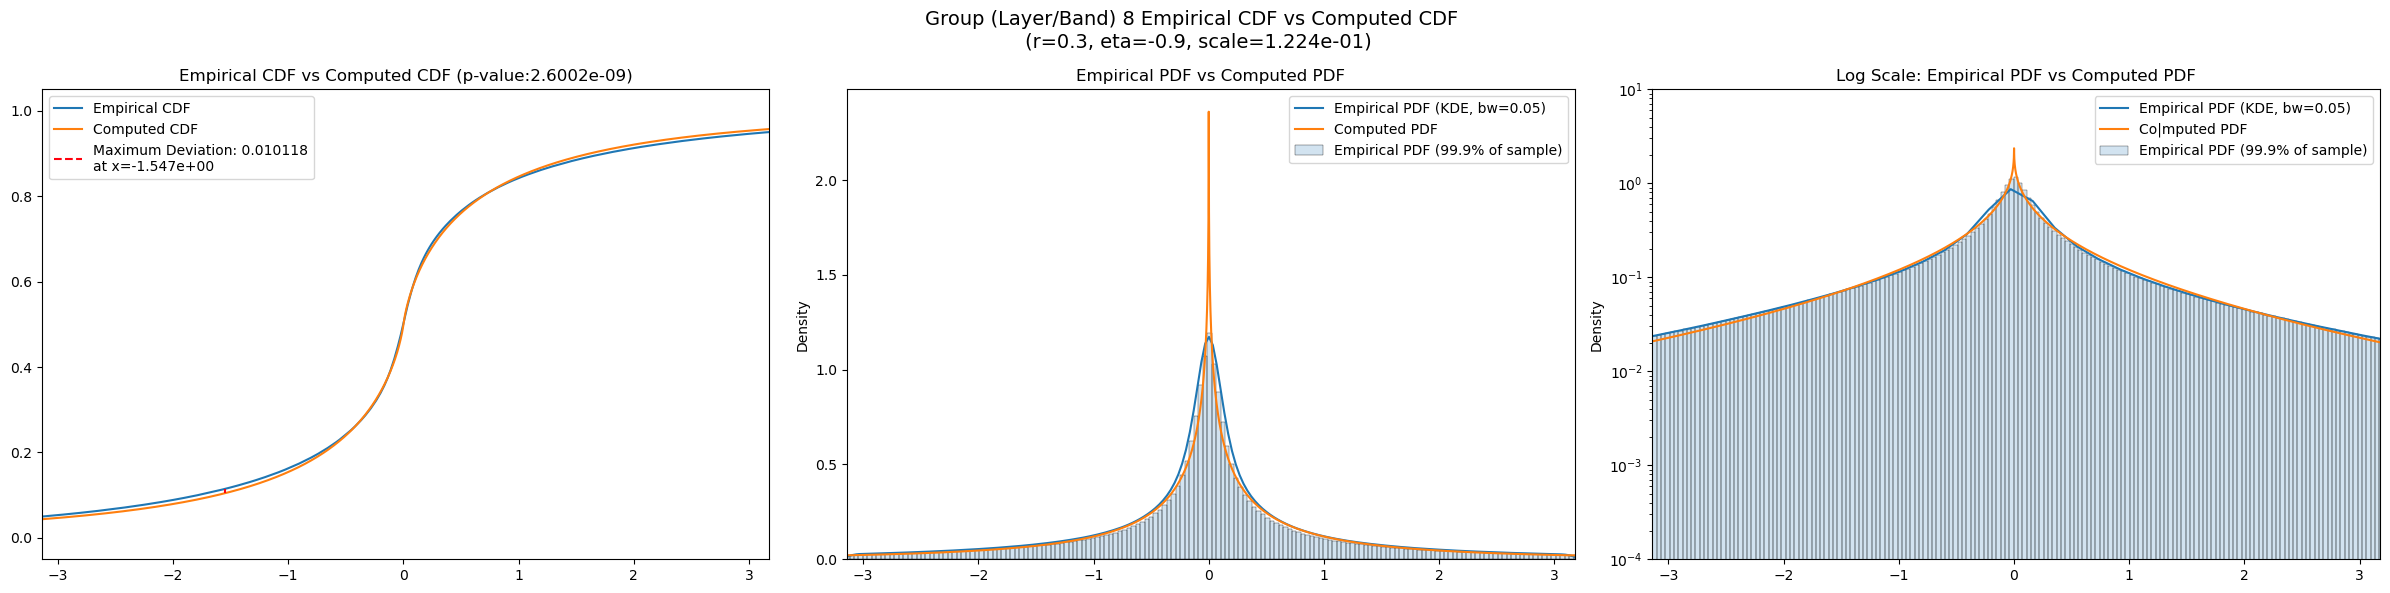

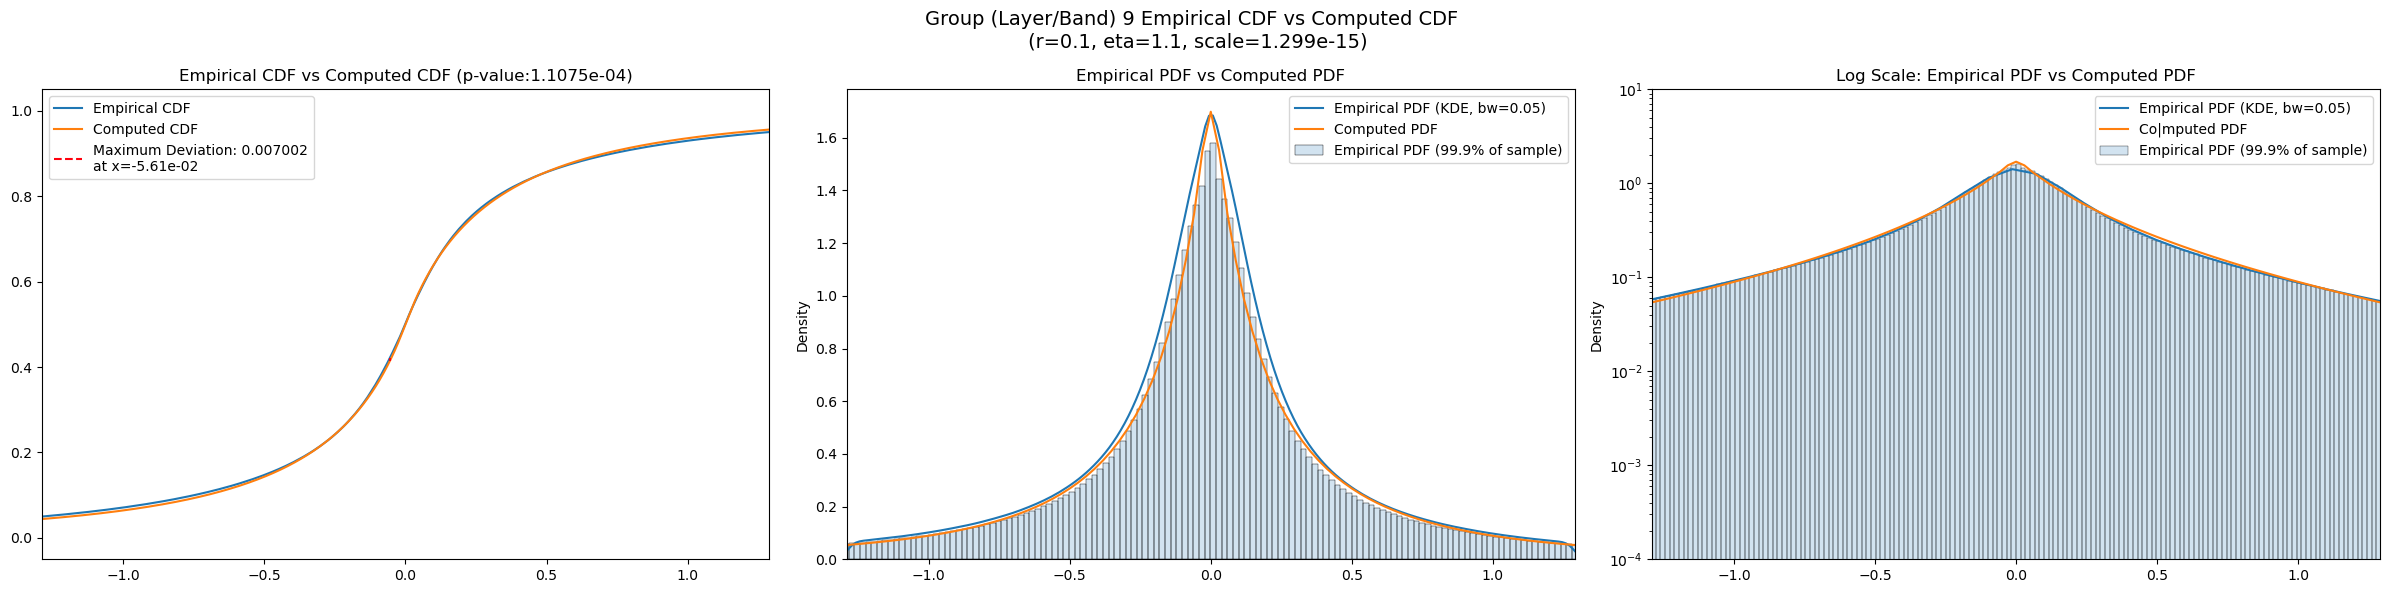

In [16]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [17]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [18]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,...,param_gaussian,kstest_stat_gaussian,kstest_pval_gaussian,param_laplace,kstest_stat_laplace,kstest_pval_laplace,param_t,kstest_stat_t,kstest_pval_t,kstest_pval_gengamma
layer,,,,,,,,,,,,,,,,,,,,,
2,20586.305000,19258.834000,21997.410000,4.579431,3.067570,6.878069,27208.0,0.013993,5.9,-1.0,...,102.063000,0.043795,8.755210e-46,84.836800,0.025430,1.021530e-15,71.353000,0.030427,2.563340e-22,0.000047
3,5586.053700,5083.016600,6169.916000,12.162226,6.823159,25.537256,108832.0,0.132980,1.4,-1.2,...,22.537400,0.133846,0.000000e+00,15.533900,0.132983,0.000000e+00,12.517100,0.132984,0.000000e+00,0.000000
4,1803.627700,1653.466300,1972.171500,9.509389,6.386564,18.200993,333298.0,0.077760,1.4,-1.2,...,16.980900,0.103746,0.000000e+00,13.103700,0.091397,0.000000e+00,10.581400,0.094235,0.000000e+00,0.000000
5,518.534850,474.725100,568.612800,10.223197,6.527225,26.452090,1149538.0,0.042990,1.4,-1.2,...,9.976240,0.089719,0.000000e+00,7.724870,0.076299,0.000000e+00,6.213070,0.079244,0.000000e+00,0.000000
6,123.448540,112.811350,135.501530,10.628438,6.988415,22.204712,4251250.0,0.013469,1.1,-1.2,...,5.257100,0.077078,0.000000e+00,4.227880,0.058911,0.000000e+00,3.411710,0.062628,0.000000e+00,0.000000
7,26.475042,23.729494,30.003483,18.552206,9.779295,60.441100,17005000.0,0.012730,1.0,-1.2,...,2.105120,0.082529,0.000000e+00,1.741310,0.060784,0.000000e+00,1.380940,0.064167,0.000000e+00,0.000000
8,5.566629,4.825312,6.911863,45.449364,13.917338,216.893890,68020000.0,0.010503,0.3,-0.9,...,0.883683,0.078867,0.000000e+00,0.765923,0.052572,0.000000e+00,0.601213,0.053543,0.000000e+00,0.000000
9,1.022354,0.857071,1.428720,105.088615,15.796925,464.369140,272080000.0,0.007386,0.1,1.1,...,0.447895,0.059487,0.000000e+00,0.394686,0.032374,0.000000e+00,0.314428,0.030537,0.000000e+00,0.000000


## Results

In [19]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [20]:
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,...,param_gaussian,kstest_stat_gaussian,kstest_pval_gaussian,param_laplace,kstest_stat_laplace,kstest_pval_laplace,param_t,kstest_stat_t,kstest_pval_t,kstest_pval_gengamma
layer,,,,,,,,,,,,,,,,,,,,,
2,20586.305000,19258.834000,21997.410000,4.579431,3.067570,6.878069,27208.0,0.013993,5.9,-1.0,...,102.063000,0.043795,8.755210e-46,84.836800,0.025430,1.021530e-15,71.353000,0.030427,2.563340e-22,0.000047
3,5586.053700,5083.016600,6169.916000,12.162226,6.823159,25.537256,108832.0,0.132980,1.4,-1.2,...,22.537400,0.133846,0.000000e+00,15.533900,0.132983,0.000000e+00,12.517100,0.132984,0.000000e+00,0.000000
4,1803.627700,1653.466300,1972.171500,9.509389,6.386564,18.200993,333298.0,0.077760,1.4,-1.2,...,16.980900,0.103746,0.000000e+00,13.103700,0.091397,0.000000e+00,10.581400,0.094235,0.000000e+00,0.000000
5,518.534850,474.725100,568.612800,10.223197,6.527225,26.452090,1149538.0,0.042990,1.4,-1.2,...,9.976240,0.089719,0.000000e+00,7.724870,0.076299,0.000000e+00,6.213070,0.079244,0.000000e+00,0.000000
6,123.448540,112.811350,135.501530,10.628438,6.988415,22.204712,4251250.0,0.013469,1.1,-1.2,...,5.257100,0.077078,0.000000e+00,4.227880,0.058911,0.000000e+00,3.411710,0.062628,0.000000e+00,0.000000
7,26.475042,23.729494,30.003483,18.552206,9.779295,60.441100,17005000.0,0.012730,1.0,-1.2,...,2.105120,0.082529,0.000000e+00,1.741310,0.060784,0.000000e+00,1.380940,0.064167,0.000000e+00,0.000000
8,5.566629,4.825312,6.911863,45.449364,13.917338,216.893890,68020000.0,0.010503,0.3,-0.9,...,0.883683,0.078867,0.000000e+00,0.765923,0.052572,0.000000e+00,0.601213,0.053543,0.000000e+00,0.000000
9,1.022354,0.857071,1.428720,105.088615,15.796925,464.369140,272080000.0,0.007386,0.1,1.1,...,0.447895,0.059487,0.000000e+00,0.394686,0.032374,0.000000e+00,0.314428,0.030537,0.000000e+00,0.000000


In [21]:
eng.quit()
remove_directory(os.path.join(CWD, "groupCDFs"))